In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import tensorflow as tf

In [14]:
import pandas as pd

# Load the dataset
df = pd.read_csv('Nat_Gas.csv')

# Display the first few rows of the dataset
df.head()


,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [15]:
# Ensure 'Dates' column is in datetime format
df['Dates'] = pd.to_datetime(df['Dates'])

# Extract the month and set it as the index
df['Months'] = df['Dates'].dt.to_period('M')
df.set_index('Months', inplace=True)

# Drop the original 'Dates' column
df.drop(columns=['Dates'], inplace=True)

# Display the first few rows to confirm changes
df.head()


<ipython-input-15-b828217e6741>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dates'] = pd.to_datetime(df['Dates'])


,Prices
Months,
2020-10,10.1
2020-11,10.3
2020-12,11.0
2021-01,10.9
2021-02,10.9


In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model
model = SARIMAX(df['Prices'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()

# Check the summary of the model
print(model_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                             Prices   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  -0.641
Date:                            Mon, 05 Aug 2024   AIC                             11.281
Time:                                    14:31:54   BIC                             19.058
Sample:                                10-31-2020   HQIC                            13.966
                                     - 09-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2254      0.275     -0.821      0.412      -0.763       0.313
ma.L1         -0.7655      0.206   

<ipython-input-24-4893179be2a9>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dates'] = pd.to_datetime(df['Dates'])
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Predicted price on 2023-05-01: 11.2


<ipython-input-24-4893179be2a9>:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dates'] = pd.to_datetime(df['Dates'])
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


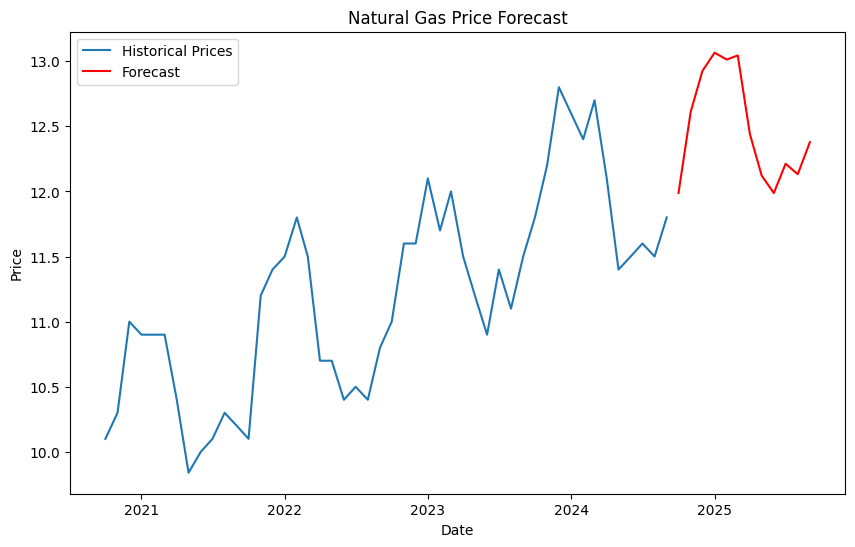

In [24]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import matplotlib.pyplot as plt

def estimate_price(data_path, input_date):
    # Load the dataset
    df = pd.read_csv(data_path)

    # Ensure 'Dates' column is in datetime format
    df['Dates'] = pd.to_datetime(df['Dates'])

    # Extract the month and set it as the index
    df['Months'] = df['Dates'].dt.to_period('M')
    df.set_index('Months', inplace=True)

    # Drop the original 'Dates' column
    df.drop(columns=['Dates'], inplace=True)

    # Fit the SARIMA model
    model = SARIMAX(df['Prices'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit()

    # Predict price on a given date
    input_date = pd.to_datetime(input_date, format='%Y-%m-%d').to_period('M')
    if input_date in df.index:
        return df.loc[input_date, 'Prices']
    else:
        last_date = df.index[-1]
        forecast_steps = (input_date.year - last_date.year) * 12 + (input_date.month - last_date.month)
        forecast = model_fit.get_forecast(steps=forecast_steps)
        forecast_index = pd.date_range(start=last_date.to_timestamp(), periods=forecast_steps + 1, freq='M')[1:].to_period('M')
        forecast_df = pd.DataFrame({'Forecast': forecast.predicted_mean}, index=forecast_index)
        if input_date in forecast_df.index:
            return forecast_df.loc[input_date, 'Forecast']
        else:
            return np.nan

def plot_forecast(data_path):
    # Load the dataset
    df = pd.read_csv(data_path)

    # Ensure 'Dates' column is in datetime format
    df['Dates'] = pd.to_datetime(df['Dates'])

    # Extract the month and set it as the index
    df['Months'] = df['Dates'].dt.to_period('M')
    df.set_index('Months', inplace=True)

    # Drop the original 'Dates' column
    df.drop(columns=['Dates'], inplace=True)

    # Fit the SARIMA model
    model = SARIMAX(df['Prices'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit()

    # Forecast for the next year
    forecast_steps = 12
    forecast = model_fit.get_forecast(steps=forecast_steps)
    forecast_index = pd.date_range(start=df.index[-1].to_timestamp(), periods=forecast_steps + 1, freq='M')[1:].to_period('M')
    forecast_df = pd.DataFrame({'Forecast': forecast.predicted_mean}, index=forecast_index)

    # Plot the forecast
    plt.figure(figsize=(10, 6))
    plt.plot(df.index.to_timestamp(), df['Prices'], label='Historical Prices')
    plt.plot(forecast_df.index.to_timestamp(), forecast_df['Forecast'], label='Forecast', color='red')
    plt.title('Natural Gas Price Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Use the function to predict price and plot the forecast
data_path = 'Nat_Gas.csv'
input_date = '2023-05-01'
predicted_price = estimate_price(data_path, input_date)
print(f'Predicted price on {input_date}: {predicted_price}')

# Plot the forecast
plot_forecast(data_path)
